In [199]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# NOTA IMPORTANTE: AQUÍ SÓLO SE MUESTRA EL CÓDIGO NECESARIO PARA APLICAR RANDOM FOREST.

# RECUÉRDESE LA IMPORTANCIA DE LOS PASOS A SEGUIR PARA IMPLEMENTAR DE FORMA ADECUADA UN MODELO:
# (1) CARGAR BASE DE DATOS Y CONOCER FRECUENCIA DE CLASES O DISTRIBUCIÓN DE ACUERDO CON EL TIPO DE PROBLEMA.
# (2) DIVIR TRAIN, TEST Y COMPROBAR SI LA DISTRIBUCIÓN DE LA VARIABLE DEPENDIENTE ES SIMILAR EN AMBOS SETS.
# (3) AJUSTAR EL MODELO Y VALORAR LAS NECESIDADES DE INVESTIGACIÓN PARA DAR MÁS PESO A UNAS MEDIDAS DE BONDAD DE AJUSTE CON RESPECTO A OTRAS. 
# (3.1) APLICAR VALIDACIÓN CRUZADA Y, EN CASO DE NECESIDAD, UN GRIDSEARCH PARA CONOCER LAS BONDADES DE AJUSTE PARA DISTINTAS PARAMETRIZACIONES.
# (4) HACER PREDICCIONES SOBRE TRAIN Y TEST CON EL FIN DE OBSERVAR EL POSIBLE SOBREAJUSTE. VALORAR EN TEST LA CAPACIDAD PREDICTIVA DEL MODELO.
# (5) SELECCIONAR LAS ALTERNATIVAS QUE MÁS NOS INTERESEN POR SU BONDAD DE AJUSTE ESPECÍFICA.
# (6) MOSTRAR BOXPLOTS DE SU PERFORMANCE EN LAS DISTINTAS VALIDACIONES PARA VALORAR LA ROBUSTEZ Y TOMAR UNA DECISIÓN.
# (7) HACER UN INFORME DE LA PARAMETRIZACIÓN Y BONDAD DE AJUSTE DEL MODELO FINAL SELECCIONADO.

In [2]:
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Escritorio/A_Doctorado/23/00_DOCENCIA/Máster Tit_Propio/Árboles/arboles.csv'  # Reemplaza con la ruta correcta de tu archivo
df = pd.read_csv(file_path)
print(df.head())
print(f'\nLa frecuencia de cada clase es: \n{df.chd.value_counts(normalize=True)}')

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

La frecuencia de cada clase es: 
0    0.65368
1    0.34632
Name: chd, dtype: float64


In [3]:
# Categorizar la variable de respuesta
df['chd'] = df['chd'].apply(lambda x: 'Yes' if x == 1 else 'No')
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49  Yes


In [66]:
#es importante tratar de forma adecuada las variables categóricas. Se convierten en numéricas con la regla: one hot encoding.
df[['famhist']] = pd.get_dummies(df[['famhist']],drop_first=True)
# Separar las variables predictoras y la variable de respuesta.
X = df.drop('chd', axis=1)
y = df['chd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [67]:
# ES IMPORTANTE QUE LA DISTRIBUCIÓN DE LAS CLASES SEA 'SIMILAR' EN TRAIN Y TEST.
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
No     0.655827
Yes    0.344173
Name: chd, dtype: float64

La frecuencia de cada clase en test es: 
No     0.645161
Yes    0.354839
Name: chd, dtype: float64


In [7]:
print(df.head())

   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11        1     49    25.30    97.20   52  Yes
1  144     0.01  4.41      28.61        0     55    28.87     2.06   63  Yes
2  118     0.08  3.48      32.28        1     52    29.14     3.81   46   No
3  170     7.50  6.41      38.03        1     51    31.99    24.26   58  Yes
4  134    13.60  3.50      27.78        1     60    25.99    57.34   49  Yes


In [68]:
# Crear el árbol de decisión base. 
# OJO, estos no son los mejores parámetros; solo son ilustraciones para la comparación con bagging.
base_classifier = DecisionTreeClassifier(min_samples_split=10, criterion='gini', max_depth = 5, random_state = 123)
base_classifier.fit(X_train, y_train)
y_pred_base = base_classifier.predict(X_test)
# Evaluar el rendimiento del modelo
accuracy_a = accuracy_score(y_test, y_pred_base)
print(f'Precisión del árbol estándar: {accuracy_a}')

Precisión del árbol estándar: 0.6989247311827957


In [296]:
# Crear el modelo de Bagging
# n_estimators int, default=10: Número de modelos a aplicar.
# max_samples int or float, default=1.0: número de valores máximos a extraer para cada modelo.
# max_features int or float, default=1.0: número de variables a utilizar para cada modelo.
# boostrap bool, default=True: con o sin reemplazo aplicado a las observaciones.
# bootstrap_features bool, default=False: con o sin reemplazo aplicado a las variables.
# oob_score bool, default=False: Out of Bag. model.oob_score_ devuelve un error medio 
# cometido en los casos fuera de la bolsa. Para todos los errores: 
# model.oob_decision_function_
import sklearn
sklearn.set_config(enable_metadata_routing=True)
bagging_model = BaggingClassifier(base_classifier, max_samples = 300, max_features = 9,n_estimators=10, random_state=123, oob_score = True)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_b = accuracy_score(y_test, y_pred_bagging)
print(f'Precisión del modelo con Bagging estándar: {accuracy_b}')
print(f'Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: \n{accuracy_b-accuracy_a}')

Precisión del modelo con Bagging estándar: 0.6559139784946236
Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: 
-0.043010752688172116


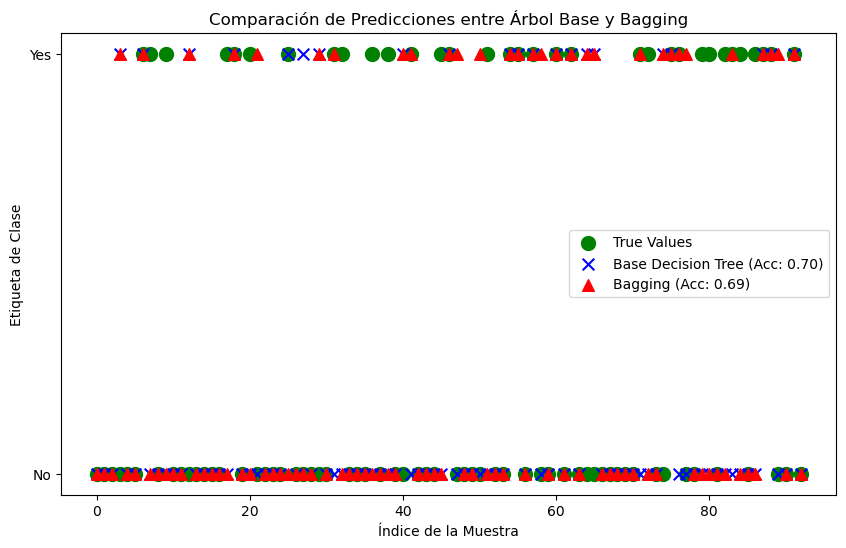

In [70]:
# Crear un gráfico de dispersión para comparar las predicciones
plt.figure(figsize=(10, 6))

plt.scatter(np.arange(len(y_test)), y_test, color='green', label='True Values', marker='o', s=100)
plt.scatter(np.arange(len(y_test)), y_pred_base, color='blue', label=f'Base Decision Tree (Acc: {accuracy_a:.2f})', marker='x', s=70)
plt.scatter(np.arange(len(y_test)), y_pred_bagging, color='red', label=f'Bagging (Acc: {accuracy_b:.2f})', marker='^', s=70)

plt.title('Comparación de Predicciones entre Árbol Base y Bagging')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Etiqueta de Clase')
plt.legend()
plt.show()

In [72]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = bagging_model.predict(X_train)
y_test_pred = bagging_model.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste. \nEsto puede deberse al modelo base seleccionado')

Se tiene un accuracy para train de: 0.8617886178861789
Se tiene un accuracy para test de: 0.6881720430107527
Nótese la diferencia en accuracy para ambos conjuntos de datos y el posible sobreajuste. 
Esto puede deberse al modelo base seleccionado


In [81]:
## tuneo y evaluación predictiva del modelo para variable dependiente categórica.
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_tree = GridSearchCV(estimator=base_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_tree.fit(X_train, y_train)
# Obtener el mejor modelo
best_model_tree = grid_search_tree.best_estimator_
print(grid_search_tree.best_estimator_)
y_pred_base = best_model_tree.predict(X_test)
accuracy_t = accuracy_score(y_test, y_pred_base)
# Evaluar el rendimiento del modelo
print(f'Precisión del árbol estándar: {accuracy_t}')

DecisionTreeClassifier(max_depth=5, min_samples_split=5, random_state=123)
Precisión del árbol estándar: 0.7096774193548387


In [87]:
# modelo ejemplo de bagging, sin buscar sus mejores parámetros, teniendo en cuenta todas las variables y 400 estimators
bagging_model = BaggingClassifier(best_model_tree, max_features = 9,n_estimators=400, random_state=123, oob_score = True)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_b = accuracy_score(y_test, y_pred_bagging)
print(f'Precisión del modelo con Bagging estándar: {accuracy_b}')
print(f'Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: \n {accuracy_b-accuracy_t}')

Precisión del modelo con Bagging estándar: 0.6989247311827957
Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: 
 -0.010752688172043001


In [83]:
# Definir el espacio de búsqueda de parámetros
param_grid = {
    'n_estimators': [10, 50, 100,250],
    'max_samples': [1,75,150,300],
    'max_features': [1,4,7,9],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [85]:
import warnings
warnings.filterwarnings("ignore")
# Configurar la búsqueda de parámetros con validación cruzada
# Nótese que el gridsearch y param_grid se está haciendo con el modelo bagging, y no con el base, el cuál también se pueden
# modificar sus parámetros.
grid_search_b = GridSearchCV(bagging_model, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda en la cuadrícula utilizando los datos
grid_search_b.fit(X_train, y_train)

# Obtener los mejores parámetros y la mejor puntuación
best_params = grid_search_b.best_params_
best_score = grid_search_b.best_score_

print(f'Mejores parámetros: {best_params}')

Mejores parámetros: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 7, 'max_samples': 75, 'n_estimators': 100}


In [86]:
# Obtener el mejor modelo
best_model_bagging = grid_search_b.best_estimator_
y_pred_best_bagging = best_model_bagging.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_b_b = accuracy_score(y_test, y_pred_best_bagging)
print(f'Precisión del modelo con Bagging CV y best_params: {accuracy_b_b}')

Precisión del modelo con Bagging CV y best_params: 0.7849462365591398


In [51]:
grid_search.best_estimator_

BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=15,
                                                   min_samples_split=100),
                  max_features=9, max_samples=150, oob_score=True,
                  random_state=123)

In [105]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = best_model_bagging.predict(X_train)
y_test_pred = best_model_bagging.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print('Nótese que ya no encontramos problemas aparentes de sobreajuste')

Se tiene un accuracy para train de: 0.8102981029810298
Se tiene un accuracy para test de: 0.7849462365591398
Nótese que ya no encontramos problemas aparentes de sobreajuste


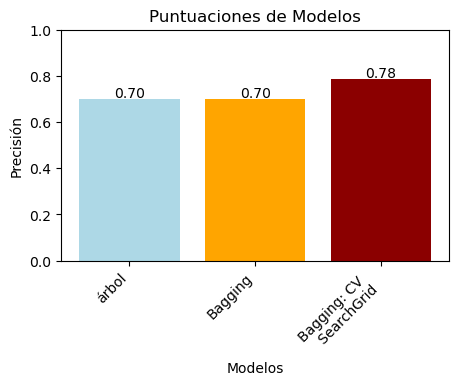

In [89]:
model_names = ['árbol', 'Bagging', 'Bagging: CV \n SearchGrid']
scores = [accuracy_a, accuracy_b, accuracy_b_b]
# Crear el diagrama de barras
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['lightblue', 'orange', 'darkred'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, 1.0)  # Ajustar el rango del eje y según tus necesidades
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')

# Añadir los valores encima de las barras centrados
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')

plt.show()

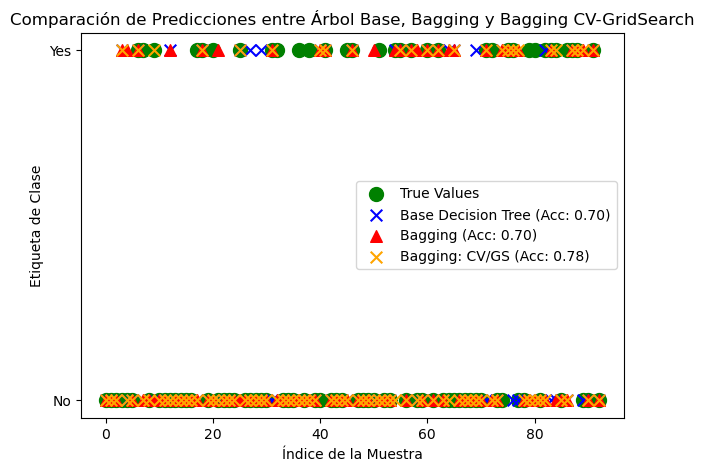

In [90]:
# Crear un gráfico de dispersión para comparar las predicciones
plt.figure(figsize=(7, 5))

plt.scatter(np.arange(len(y_test)), y_test, color='green', label='True Values', marker='o', s=100)
plt.scatter(np.arange(len(y_test)), y_pred_base, color='blue', label=f'Base Decision Tree (Acc: {accuracy_a:.2f})', marker='x', s=70)
plt.scatter(np.arange(len(y_test)), y_pred_bagging, color='red', label=f'Bagging (Acc: {accuracy_b:.2f})', marker='^', s=70)
plt.scatter(np.arange(len(y_test)), y_pred_best_bagging, color='orange', label=f'Bagging: CV/GS (Acc: {accuracy_b_b:.2f})', marker='x', s=70)
plt.title('Comparación de Predicciones entre Árbol Base, Bagging y Bagging CV-GridSearch')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Etiqueta de Clase')
plt.legend()
plt.show()

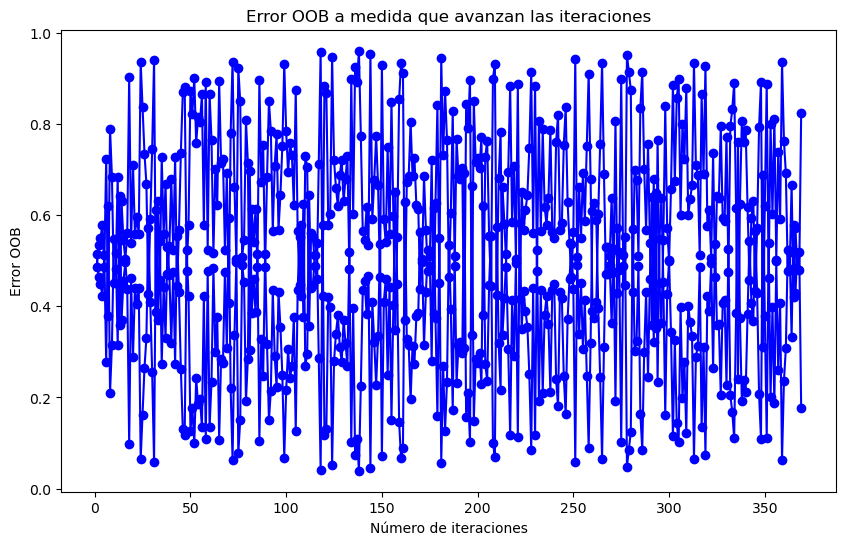

In [93]:
# Crear el gráfico del error OOB
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(best_model_bagging.oob_decision_function_) + 1), best_model_bagging.oob_decision_function_, marker='o', linestyle='-', color='blue')
plt.title('Error OOB a medida que avanzan las iteraciones')
plt.xlabel('Número de iteraciones')
plt.ylabel('Error OOB')
plt.show()

In [95]:
# Obtener resultados del grid search
results = pd.DataFrame(grid_search_b.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_bootstrap_features,param_max_features,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018785,0.001899,0.002260,0.003604,True,True,1,1,10,"{'bootstrap': True, 'bootstrap_features': True...",0.648649,0.648649,0.662162,0.662162,0.657534,0.655831,0.006103,58
1,0.050713,0.002331,0.003276,0.004587,True,True,1,1,50,"{'bootstrap': True, 'bootstrap_features': True...",0.648649,0.648649,0.662162,0.662162,0.657534,0.655831,0.006103,58
2,0.099566,0.006890,0.006867,0.005637,True,True,1,1,100,"{'bootstrap': True, 'bootstrap_features': True...",0.648649,0.648649,0.662162,0.662162,0.657534,0.655831,0.006103,58
3,0.241524,0.004299,0.016009,0.003678,True,True,1,1,250,"{'bootstrap': True, 'bootstrap_features': True...",0.648649,0.648649,0.662162,0.662162,0.657534,0.655831,0.006103,58
4,0.013057,0.002837,0.000000,0.000000,True,True,1,75,10,"{'bootstrap': True, 'bootstrap_features': True...",0.635135,0.608108,0.594595,0.648649,0.630137,0.623325,0.019412,93


In [115]:
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results = results.sort_values(by='rank_test_score', ascending=True).head(5)
print(sorted_results)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
38        0.126385      0.004191         0.008600        0.001894   
39        0.325631      0.006577         0.012550        0.005109   
54        0.139220      0.003463         0.009127        0.001859   
85        0.057800      0.001636         0.002826        0.002603   
122       0.165358      0.001651         0.007775        0.001716   

    param_bootstrap param_bootstrap_features param_max_features  \
38             True                     True                  7   
39             True                     True                  7   
54             True                     True                  9   
85             True                    False                  4   
122            True                    False                  9   

    param_max_samples param_n_estimators  \
38                 75                100   
39                 75                250   
54                 75                100   
85    

In [116]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[0]
res_2 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[1]
res_3 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[2]
res_4 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[3]
res_5 = sorted_results[['split0_test_score', 'split1_test_score','split2_test_score', 'split3_test_score']].iloc[4]

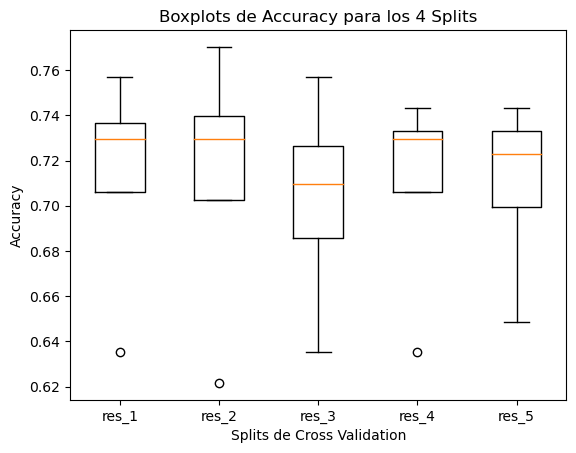

In [117]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()
# Nótese en la solución que boxplots con gran amplitud no son deseables, ya que se caracterizan por poca robustez de la solución

In [99]:
grid_search_b.best_estimator_

BaggingClassifier(bootstrap_features=True,
                  estimator=DecisionTreeClassifier(max_depth=5,
                                                   min_samples_split=5,
                                                   random_state=123),
                  max_features=7, max_samples=75, n_estimators=100,
                  oob_score=True, random_state=123)

In [121]:
sorted_results['params'].iloc[0]

{'bootstrap': True,
 'bootstrap_features': True,
 'max_features': 7,
 'max_samples': 75,
 'n_estimators': 100}

In [123]:
# nótese que "**" es para desempaquetar una lista de valores.
bagging_0 = BaggingClassifier(best_model_tree,**sorted_results['params'].iloc[0],random_state=123)
bagging_0.fit(X_train, y_train)
res_0 = bagging_0.predict(X_test)

bagging_1 = BaggingClassifier(best_model_tree,**sorted_results['params'].iloc[1],random_state=123)
bagging_1.fit(X_train, y_train)
res_1 = bagging_1.predict(X_test)

bagging_2 = BaggingClassifier(best_model_tree,**sorted_results['params'].iloc[2],random_state=123)
bagging_2.fit(X_train, y_train)
res_2 = bagging_2.predict(X_test)

bagging_3 = BaggingClassifier(best_model_tree,**sorted_results['params'].iloc[3],random_state=123)
bagging_3.fit(X_train, y_train)
res_3 = bagging_3.predict(X_test)

bagging_4 = BaggingClassifier(best_model_tree,**sorted_results['params'].iloc[4],random_state=123)
bagging_4.fit(X_train, y_train)
res_4 = bagging_4.predict(X_test)

In [124]:
accuracy_score(y_test,res_0)

0.7849462365591398

In [128]:
# A continuación, se observa, igualmente, las matrices de confusión para determinar - en caso de que haya una preferencia - si se busca 
# más sensibilidad o especificidad (en ámbitos como en el de la salud, esto es crucial)
print('Resultados para Modelo 0')
print(classification_report(y_test, res_0))
print('Resultados para Modelo 1')
print(classification_report(y_test, res_1))
print('Resultados para Modelo 2')
print(classification_report(y_test, res_2))
print('Resultados para Modelo 3')
print(classification_report(y_test, res_3))
print('Resultados para Modelo 4')
print(classification_report(y_test, res_4))
print('\nEn este caso, el modelo seleccionado como "best_estimator", no sólo \nes el que presenta mejor puntuación media, sino también mejor balance medio')

Resultados para Modelo 0
              precision    recall  f1-score   support

          No       0.79      0.90      0.84        60
         Yes       0.76      0.58      0.66        33

    accuracy                           0.78        93
   macro avg       0.78      0.74      0.75        93
weighted avg       0.78      0.78      0.78        93

Resultados para Modelo 1
              precision    recall  f1-score   support

          No       0.75      0.90      0.82        60
         Yes       0.71      0.45      0.56        33

    accuracy                           0.74        93
   macro avg       0.73      0.68      0.69        93
weighted avg       0.74      0.74      0.72        93

Resultados para Modelo 2
              precision    recall  f1-score   support

          No       0.71      0.85      0.77        60
         Yes       0.57      0.36      0.44        33

    accuracy                           0.68        93
   macro avg       0.64      0.61      0.61        93

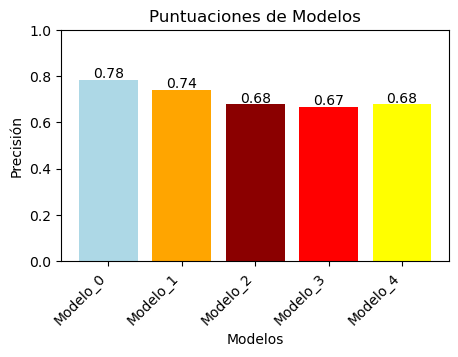

Recuérdese no valorar únicamente estas puntuaciones, sino también los boxplots.
En ocasiones puede ser mejor sacrificar algo de precisión por mayor sensibilidad, o especificidad


In [140]:
model_names = ['Modelo_0', 'Modelo_1', 'Modelo_2', 'Modelo_3','Modelo_4']
scores = [accuracy_score(y_test,res_0), accuracy_score(y_test,res_1), accuracy_score(y_test,res_2),accuracy_score(y_test,res_3),accuracy_score(y_test,res_4)]
# Crear el diagrama de barras
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['lightblue', 'orange', 'darkred','red','yellow'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, 1.0)  # Ajustar el rango del eje y según tus necesidades
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')

# Añadir los valores encima de las barras centrados
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')

plt.show()
print('Recuérdese no valorar únicamente estas puntuaciones, sino también los boxplots.\nEn ocasiones puede ser mejor sacrificar algo de precisión por mayor sensibilidad, o especificidad')

A CONTINUACIÓN, SE REALIZARÁ EL EJEMPLO PARA EL CASO DE PROBLEMAS DE REGRESIÓN.

In [141]:
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Escritorio/A_Doctorado/23/00_DOCENCIA/Máster Tit_Propio/Árboles/compress.csv'  # Reemplaza con la ruta correcta de tu archivo

compress = pd.read_csv(file_path)
compress.head()

,cstrength,cement,blast,ash,water,plasti,aggreg,fineagg,age
0,79.99,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,61.89,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,40.27,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,41.05,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,44.30,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [258]:
# Separar las variables predictoras y la variable de respuesta.
X_c = compress.drop('cstrength', axis=1)
y_c = compress['cstrength']

arbol_r = DecisionTreeRegressor(min_samples_split=30, criterion='squared_error', max_depth = 4, ccp_alpha = 0.01)
# Crear un conjunto de entrenamiento y uno de prueba
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=123)
# Construir el modelo de árbol de decisiones
arbol_r.fit(X_train_c, y_train_c)

params_c = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_split': [5, 10, 20, 50, 100],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
# Definir las métricas de evaluación que deseas utilizar
scoring_metrics_c = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
}
# cv = crossvalidation
grid_search_c = GridSearchCV(estimator=arbol_r, 
                           param_grid=params_c, 
                           cv=4, scoring = scoring_metrics_c, refit='MAE')
grid_search_c.fit(X_train_c, y_train_c)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=0.01, max_depth=4,
                                             min_samples_split=30),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_split': [5, 10, 20, 50, 100]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error),
                      'MSE': make_scorer(mean_squared_error),
                      'RMSE': make_scorer(<lambda>)})

In [259]:
gs_cv_arbol_r = pd.DataFrame(grid_search_c.cv_results_)
print(gs_cv_arbol_r.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_split',
       'params', 'split0_test_MAE', 'split1_test_MAE', 'split2_test_MAE',
       'split3_test_MAE', 'mean_test_MAE', 'std_test_MAE', 'rank_test_MAE',
       'split0_test_MSE', 'split1_test_MSE', 'split2_test_MSE',
       'split3_test_MSE', 'mean_test_MSE', 'std_test_MSE', 'rank_test_MSE',
       'split0_test_RMSE', 'split1_test_RMSE', 'split2_test_RMSE',
       'split3_test_RMSE', 'mean_test_RMSE', 'std_test_RMSE',
       'rank_test_RMSE'],
      dtype='object')


In [260]:
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results_arbol_r = gs_cv_arbol_r.sort_values(by='mean_test_MAE', ascending=True).head(5)

In [261]:
sorted_results_arbol_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[0]

split0_test_MAE    4.783168
split1_test_MAE    4.694309
split2_test_MAE    4.882428
split3_test_MAE    5.273672
Name: 45, dtype: float64

In [262]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1_R = sorted_results_arbol_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[0]
res_2_R = sorted_results_arbol_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[1]
res_3_R = sorted_results_arbol_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[2]

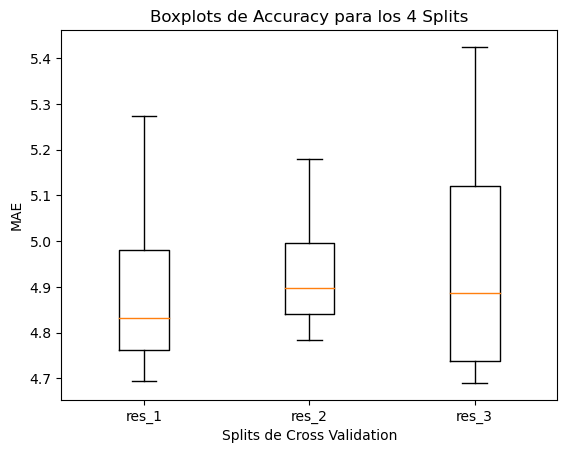

In [263]:
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1_R.values,res_2_R.values,res_3_R.values], labels = ['res_1','res_2','res_3'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('MAE')
plt.show()

In [264]:
arbol_r_best = grid_search_c.best_estimator_
y_train_pred_a = arbol_r_best.predict(X_train_c)
y_test_pred_a = arbol_r_best.predict(X_test_c)
print(f'Se tiene un MAE para train de: {np.sqrt(mean_squared_error(y_train_c, y_train_pred_a))}')
print(f'Se tiene un MAE para test de: {np.sqrt(mean_squared_error(y_test_c, y_test_pred_a))}')

Se tiene un MAE para train de: 11.950450269281113
Se tiene un MAE para test de: 12.182911280126095


In [266]:
arbol_r_best = grid_search_c.best_estimator_
y_pred_arbol_r = arbol_r_best.predict(X_test_c)
mae_a_b = mean_absolute_error(y_test_c, y_pred_arbol_r)
print(f'MAE del modelo árbol de regresión: {mae_a_b}')

MAE del modelo árbol de regresión: 9.656857931891684


In [267]:
# modelo ejemplo de bagging, sin buscar sus mejores parámetros, teniendo en cuenta todas las variables y 400 estimators
bagging_model = BaggingRegressor(arbol_r_best, max_features = 8,n_estimators=150, random_state=123, oob_score = True)
bagging_model.fit(X_train_c, y_train_c)
y_pred_bagging_r = bagging_model.predict(X_test_c)

# Evaluar el rendimiento del modelo
mae_b = mean_absolute_error(y_test_c, y_pred_bagging_r)
print(f'Precisión del modelo con Bagging estándar: {mae_b}')
print(f'Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: \n {mae_b-mae_a_b}')

Precisión del modelo con Bagging estándar: 8.952888914979454
Se observa una diferencia del modelo baggin con respecto al árbol de decisión de: 
 -0.7039690169122306


In [284]:
# Definir el espacio de búsqueda de parámetros
param_grid = {
    'n_estimators': [10, 50, 100,250,300],
    'max_samples': [1,75,150,300],
    'max_features': [1,4,7,9],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
# Definir las métricas de evaluación que deseas utilizar
scoring_metrics_c = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error)
}

In [285]:
grid_bagg_r = GridSearchCV(bagging_model, param_grid, cv=5, scoring=scoring_metrics_c,  refit='MAE')
grid_bagg_r.fit(X_train_c, y_train_c)
# Obtener los mejores parámetros y la mejor puntuación
best_params_b_r = grid_bagg_r.best_params_
best_score_b_r = grid_bagg_r.best_score_

In [286]:
print(f'Mejores parámetros: {best_params_b_r}')
print(f'El MAE más bajo es: {best_score_b_r}')

Mejores parámetros: {'bootstrap': True, 'bootstrap_features': True, 'max_features': 1, 'max_samples': 1, 'n_estimators': 10}
El MAE más bajo es: 14.18157989652624


In [287]:
res_bagging_r = pd.DataFrame(grid_bagg_r.cv_results_)
                             
# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results_b_r = res_bagging_r.sort_values(by='mean_test_MAE', ascending=False).head(5)
print(sorted_results_b_r)

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.012292      0.005455         0.001000        0.001549   
40        0.009693      0.007936         0.002901        0.005802   
42        0.097561      0.006156         0.000000        0.000000   
120       0.009250      0.007579         0.003147        0.006294   
100       0.008313      0.007177         0.001122        0.002244   

    param_bootstrap param_bootstrap_features param_max_features  \
0              True                     True                  1   
40             True                     True                  7   
42             True                     True                  7   
120            True                    False                  7   
100            True                    False                  4   

    param_max_samples param_n_estimators  \
0                   1                 10   
40                  1                 10   
42                  1                100   
120   

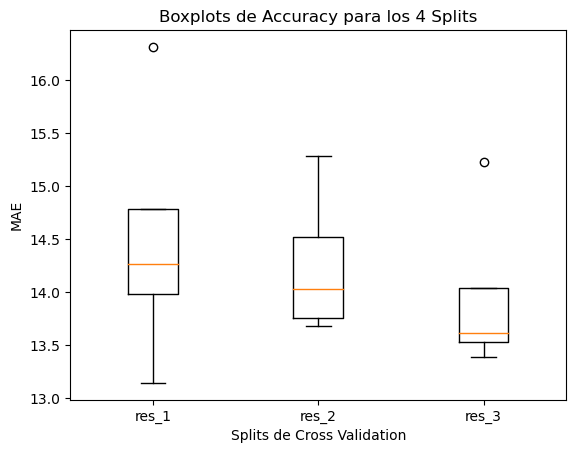

In [288]:
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1_B_R = sorted_results_b_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[0]
res_2_B_R = sorted_results_b_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[1]
res_3_B_R = sorted_results_b_r[['split0_test_MAE', 'split1_test_MAE','split2_test_MAE','split3_test_MAE']].iloc[2]
# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1_B_R.values,res_2_B_R.values,res_3_B_R.values], labels = ['res_1','res_2','res_3'])
plt.title('Boxplots de Accuracy para los 4 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('MAE')
plt.show()

In [290]:
grid_bagg_r_best = grid_bagg_r.best_estimator_
y_train_pred_b_b = grid_bagg_r_best.predict(X_train_c)
y_test_pred_b_b = grid_bagg_r_best.predict(X_test_c)
print(f'Se tiene un MAE para train de: {np.sqrt(mean_squared_error(y_train_c, y_train_pred_b_b))}')
print(f'Se tiene un MAE para test de: {np.sqrt(mean_squared_error(y_test_c, y_test_pred_b_b))}')

Se tiene un MAE para train de: 17.686305744923462
Se tiene un MAE para test de: 17.81273740376627


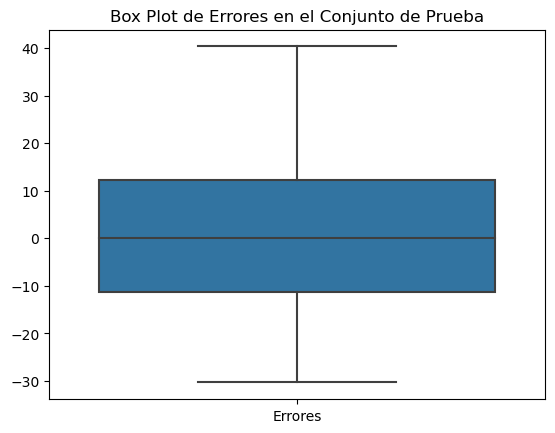

In [239]:
errores = y_test_c - y_test_pred_b_b

# Convertir los errores a un DataFrame
errores_df = pd.DataFrame({'Errores': errores})
# Box Plot de los errores en el conjunto de prueba
sns.boxplot(errores_df)
plt.title('Box Plot de Errores en el Conjunto de Prueba')
plt.show()

In [240]:
# Calcular diferentes medidas de bondad de ajuste
mae = mean_absolute_error(y_test_c, y_test_pred_b_b)
mse = mean_squared_error(y_test_c, y_test_pred_b_b)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_c, y_test_pred_b_b)

# Imprimir las métricas
print(f'MAE (Error Absoluto Medio): {mae:.2f}')
print(f'MSE (Error Cuadrático Medio): {mse:.2f}')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}')

MAE (Error Absoluto Medio): 13.03
MSE (Error Cuadrático Medio): 257.92
RMSE (Raíz del Error Cuadrático Medio): 16.06
R²: -0.00


In [2]:
indices = np.arange(1, len(y_test_c) + 1)

plt.figure(figsize=(8, 6))
plt.scatter(indices, y_test_c, color='darkgreen', label='reales')  # Puedes ajustar el color según tus preferencias

plt.scatter(indices, y_pred_bagging_r, color='red', alpha=0.5, label='bagging_original')  # Puedes ajustar el color y la transparencia según tus preferencias


plt.scatter(indices, y_test_pred_b_b, color='yellow', alpha=0.5, label='bagging_grid')  # Puedes ajustar el color y la transparencia según tus preferencias

plt.scatter(indices, y_pred_arbol_r, color='orange', alpha=0.5, label='arbol_r')  # Puedes ajustar el color y la transparencia según tus preferencias

plt.title('Scatter Plot de valores reales vs árbol de regresión vs bagging regresión')
plt.xlabel('Observaciones')
plt.ylabel('Valores')
plt.legend()  # Agregar leyenda
plt.grid(True)
plt.show()

NameError: name 'np' is not defined